In [ ]:
import numpy as np
import pandas as pd
import torch
from model import EEGNet, CNN_BiLSTM, EEGDataset, create_dataloaders, train_model, plot_metrics, save_training_stats
from explore import apply_bandpass_filter
from load_data import get_dataset
from feature_extraction import extract_all_features_per_trial

In [28]:
train_df = get_dataset("data/SMNI_CMI_TRAIN/Train/")
test_df = get_dataset("data/SMNI_CMI_TEST/Test/")

dataset loaded from tmp/dea5a0ab2c.pickle
dataset loaded from tmp/0d05880708.pickle


In [29]:
df = pd.concat([train_df, test_df], ignore_index=True)

filtered_df = df.groupby(['name', 'trial number', 'sensor position']) \
               .apply(apply_bandpass_filter) \
               .reset_index(drop=True)

C:\Users\Bruno\AppData\Local\Temp\ipykernel_14428\2937941771.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(apply_bandpass_filter) \


In [30]:
print(filtered_df.shape)
print(filtered_df.head())

(15532032, 10)
   trial number sensor position  sample num  sensor value subject identifier  \
0             0             AF1           0        -2.146                  a   
1             0             AF1           1        -2.146                  a   
2             0             AF1           2        -1.658                  a   
3             0             AF1           3        -0.682                  a   
4             0             AF1           4         2.248                  a   

  matching condition  channel         name      time  filtered_sensor_value  
0             S1 obj        4  co2a0000364  0.000000              -0.004665  
1             S1 obj        4  co2a0000364  0.003906              -0.040292  
2             S1 obj        4  co2a0000364  0.007812              -0.165046  
3             S1 obj        4  co2a0000364  0.011719              -0.429810  
4             S1 obj        4  co2a0000364  0.015625              -0.797100  


In [31]:
def extract_eeg_sequences(df: pd.DataFrame, group_label: int):
    eeg_segments = []
    labels = []
    ids = []
    grouped = df.groupby(['name', 'trial number'])

    for (name, trial), group in grouped:
        pivot = group.pivot_table(
            index='sensor position',
            columns='time',
            values='filtered_sensor_value'
        )

        eeg_segments.append(pivot.values)
        labels.append(group_label)
        ids.append(group["name"].iloc[0])
    return np.stack(eeg_segments), np.array(labels), np.array(ids)

alcohol_df = filtered_df[filtered_df['subject identifier'] == 'a']
control_df = filtered_df[filtered_df['subject identifier'] == 'c']

X_a, y_a, y_id_a = extract_eeg_sequences(alcohol_df, group_label=0)
X_c, y_c, y_id_c = extract_eeg_sequences(control_df, group_label=1)

X_full = np.concatenate([X_a, X_c], axis=0)
y_full = np.concatenate([y_a, y_c], axis=0)
id_full = np.concatenate([y_id_a, y_id_c], axis=0)

In [32]:
id_full.shape

(924,)

In [33]:
print(X_full.shape) #924 measurements, 64 sensors, 256 time points

(924, 64, 256)


In [34]:
print(y_full.shape)

(924,)


In [ ]:
train_loader, val_loader = create_dataloaders(X_full, y_full, id_full, batch_size=32)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EEGNet(num_channels=64, num_time_points=256, num_classes=2)
print("Model Summary:")
print(model)

Train set unique IDs: ['co2a0000364' 'co2a0000365' 'co2a0000368' 'co2a0000369' 'co2a0000370'
 'co2a0000375' 'co2c0000337' 'co2c0000339' 'co2c0000340' 'co2c0000341'
 'co2c0000344' 'co2c0000345']
Val set unique IDs: ['co2a0000371' 'co2a0000372' 'co2c0000338' 'co2c0000342']
Model Summary:
EEGNet(
  (conv1): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (depthwise_conv): Conv2d(8, 16, kernel_size=(64, 1), stride=(1, 1), groups=8, bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation1): ELU(alpha=1.0)
  (avgpool1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (dropout1): Dropout(p=0.5, inplace=False)
  (separable_conv): Sequential(
    (0): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), bias=False)
    (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (bn3

In [48]:
model2 = CNN_BiLSTM()
print("Model Summary:")
print(model2)

Model Summary:
CNN_BiLSTM(
  (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu2): ReLU()
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu3): ReLU()
  (conv4): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu4): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bi_lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (drop3): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=64, out_features=2, bias=True)
)


In [36]:
train_loader

In [37]:
sample_X, _ = next(iter(train_loader))
print(sample_X.shape) 

torch.Size([32, 1, 64, 256])


In [43]:
best_model, stats = train_model(
    model2,
    train_loader,
    val_loader,
    epochs=100,
    lr=1e-3,
    device="cuda" if torch.cuda.is_available() else "cpu",
    patience=12,      # stop after 12 non-improving epochs
    min_delta=0.001,  # require at least 0.001 drop in val-loss
)
torch.save(model.state_dict(), "models/signal_only_model.pt")

Epoch 001/100 | Train 0.7009 | Val 0.6992 | Acc 0.5000
Epoch 002/100 | Train 0.6927 | Val 0.6845 | Acc 0.5381
Epoch 003/100 | Train 0.6378 | Val 0.3685 | Acc 0.8814
Epoch 004/100 | Train 0.5093 | Val 0.2836 | Acc 0.8983
Epoch 005/100 | Train 0.3390 | Val 0.2220 | Acc 0.9025
Epoch 006/100 | Train 0.2688 | Val 0.2405 | Acc 0.9110
Epoch 007/100 | Train 0.1324 | Val 0.2285 | Acc 0.9280
Epoch 008/100 | Train 0.0812 | Val 0.1803 | Acc 0.9280
Epoch 009/100 | Train 0.0697 | Val 0.0640 | Acc 0.9703
Epoch 010/100 | Train 0.0334 | Val 0.2002 | Acc 0.9322
Epoch 011/100 | Train 0.0078 | Val 0.1750 | Acc 0.9534
Epoch 012/100 | Train 0.0043 | Val 0.9599 | Acc 0.8432
Epoch 013/100 | Train 0.0403 | Val 0.2934 | Acc 0.9195
Epoch 014/100 | Train 0.0225 | Val 0.1140 | Acc 0.9619
Epoch 015/100 | Train 0.0200 | Val 0.1477 | Acc 0.9576
Epoch 016/100 | Train 0.0536 | Val 0.3369 | Acc 0.8898
Epoch 017/100 | Train 0.0111 | Val 1.0158 | Acc 0.8178
Epoch 018/100 | Train 0.0176 | Val 0.2100 | Acc 0.9364
Epoch 019/

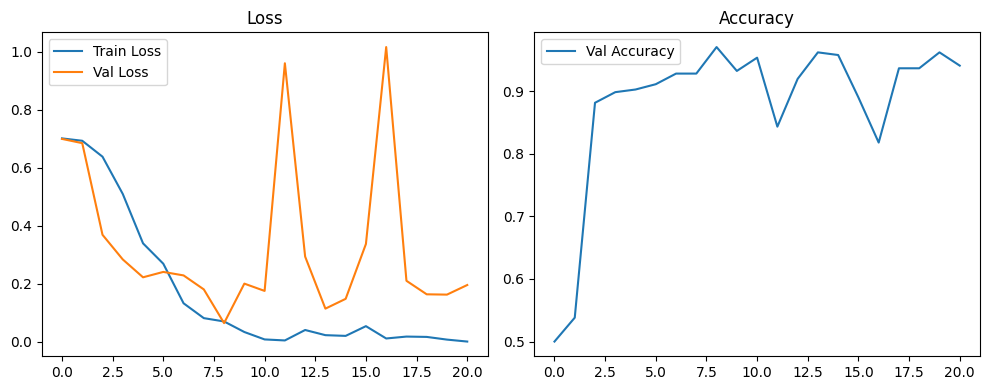

In [46]:
plot_metrics(stats)
save_training_stats(stats, "training_stats.csv")

In [45]:
from torch.utils.data import DataLoader

def evaluate_on_full_data(model, X, y, batch_size=32, device='cpu'):
    model.eval()
    dataset = EEGDataset(X, y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    correct = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            pred = output.argmax(dim=1)
            correct += pred.eq(y_batch).sum().item()

    return correct / len(dataset)

acc = evaluate_on_full_data(model, X_full, y_full, device=device)
print(f"Accuracy on all data: {acc:.4f}")

Accuracy on all data: 0.9589
